In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
from scipy.stats import norm
from scipy.stats import anderson_ksamp
from statsmodels.stats.proportion import proportions_ztest

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

**Контекст**

В связи с постановлением Центрального Банка
наше текущее содержание диалога с клиентом (скрипт)
операторов считается слишком жёстким,
и нам нужно придумать более мягкий скрипт,
который будет всё ещё иметь хорошие показатели.
У нас есть два варианта более мягкого скрипта,
и мы хотим выбрать лучший из них.
При этом у нас нет времени 
чтобы ждать вызревания долгих метрик вроде PV.
        
**Тест**

Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где одной части мы продаём одним вариантом скрипта,
другой - другим.
Целью этого теста
является поиск наилучшего скрипта.

**Статистические вводные**

Уровень значимости 5%.
Мы хотели бы различать 8%-ное
изменение целевой метрики
с вероятностью 80%.

Посмотрим на имеющиеся исторические данные.

In [ ]:
hist = pd.read_csv('/content/gdrive/MyDrive/AB tink/hist_telesales.csv', index_col=0)

In [ ]:
hist.head()

,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
ID,,,,,
0,1,0,90,0,-90
1,0,0,5,0,-5
2,0,0,68,0,-68
3,1,0,22,0,-22
4,1,0,22,0,-22


In [ ]:
hist.corr()

,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
Флаг дозвона,1.000000,0.537421,0.340345,0.483508,0.398258
Флаг продажи,0.537421,1.000000,0.632489,0.899682,0.741486
Расходы,0.340345,0.632489,1.000000,0.567317,0.144875
PV,0.483508,0.899682,0.567317,1.000000,0.897001
NPV,0.398258,0.741486,0.144875,0.897001,1.000000



У нас нет времени ждать созревания PV (а заодно и NPV), но эта метрика довольно сильно коррелирует с флагом продажи, поэтому в качестве метрики для теста выберем его частоту.

Альтернатива: $p_{1} > p_{2}$, где $p_{1}$ частота продаж для контроля, а $p_{2}$ - для теста.

Оценим MDE :


In [ ]:
p = hist['Флаг продажи'].mean() 
mde = p * 0.08
print('mde:', mde)

mde: 0.024173722647967737


Вероятности ошибок первого и второго рода:

In [ ]:
alpha = 0.05 
beta = 0.2 

Расчитаем размер выборки.

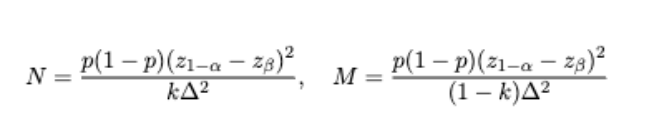

In [ ]:
k = 1/2 # доля теста (контроля)
n = round(p * (1-p) *(norm.ppf(1-alpha) - norm.ppf(beta))**2 / (k * mde**2))
print('Размер выборки:', n)

Размер выборки: 4462


Получили выборки. Проводим тест.

In [ ]:
A = pd.read_csv('/content/gdrive/MyDrive/AB tink/Контроль.csv', index_col=0)
B = pd.read_csv('/content/gdrive/MyDrive/AB tink/Тест.csv', index_col=0)

c1 = sum(A['Флаг продажи'])
c2 = sum(B['Флаг продажи'])

_, p_v = proportions_ztest(
    [c1, c2], 
    [n, n],
    alternative='larger'
)

print('p-value:', p_v)

p-value: 0.06241334945981705



Получили, что статистически значимых различий нет. Отклонить нулевую гипотезу не можем, но в то же время не можем принять и альтернативную.


Хочется понять есть ли реальные различия. Посчитаем наблюдаемое изменение и сравним с полученным ранее прогнозом mde.

In [ ]:
p1 = c1 / n 
p2 = c2 / n 
print('наблюдаемое изменение:', p1-p2)
print('минимальный замечаемый тестом эффект:', mde)

наблюдаемое изменение: 0.014791573285522164 0.05176470588235286
минимальный замечаемый тестом эффект: 0.024173722647967737


Оцененное значение больше чем наблюдаемое. Это значит, что мы не можем утвержать 

Получается, не можем утверждать, что метрика на тесте и контроле различается. Но выбор сделать надо, так как предыдущий вариант скрипта в любом случае снимается. Можно выбрать вариант скрипта с большим числом продаж, так как этот параметр коррелировал с PV на исторических данных.